## Discrete Diffusion (D3PM) on Sneakers

Trains a discrete denoising diffusion model on the sneakers dataset and preprocessing from `DDPM_Sneakers.ipynb`.


In [1]:
%%bash

if [ ! -d data/ ]; then
    curl -sO 'https://courses.cv-gml.ru/storage/tasks/sneaker-generation/data.zip'
    unzip -qo data.zip
fi


In [2]:
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = torch.device(_device)

torch.manual_seed(0)
np.random.seed(0)

device


device(type='cuda')

In [3]:
class SneakersDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images_dir="images",
        input_size=None,
        target_size=None,
        use_rgb: bool = False,
        root_dir: str = "data",
    ):
        self.images_dir = os.path.join(root_dir, images_dir)
        self.input_size = input_size
        self.target_size = target_size
        self.use_rgb = use_rgb
        files = os.listdir(self.images_dir)
        self.all_images = sorted([file for file in files if file.endswith(".jpg")])

    def __len__(self):
        return len(self.all_images)

    def _read_image(self, image_path: str, size):
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            raise FileNotFoundError(image_path)

        if self.use_rgb:
            image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            if size is not None:
                image = cv2.resize(image, size)
            image = (image.astype(np.float32) / 255.0) * 2.0 - 1.0
            return torch.from_numpy(image).permute(2, 0, 1)

        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        if size is not None:
            image = cv2.resize(image, size)
        image = (image.astype(np.float32) / 255.0) * 2.0 - 1.0
        return torch.from_numpy(image).unsqueeze(0)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.all_images[idx])

        if self.input_size is not None:
            x_in = self._read_image(image_path, self.input_size)
            x_tgt = self._read_image(image_path, self.target_size)
            return x_in, x_tgt

        x = self._read_image(image_path, self.target_size)
        return x, 0


def data2img(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().float().numpy()
    x = 0.5 * x + 0.5
    return np.clip(x, 0.0, 1.0)


def to_display(x):
    x = data2img(x)
    if x.ndim == 3 and x.shape[0] in (1, 3):
        x = np.transpose(x, (1, 2, 0))
    if x.ndim == 3 and x.shape[2] == 1:
        x = x[:, :, 0]
    return x


def visualize_images(dataset, n_rows, n_cols, seed=0):
    n_samples = n_rows * n_cols

    rng = np.random.default_rng(seed)
    if len(dataset) >= n_samples:
        sample_indices = rng.choice(len(dataset), n_samples, replace=False)
    else:
        sample_indices = rng.choice(len(dataset), n_samples, replace=True)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        item = dataset[int(sample_index)]
        x = item[0] if isinstance(item, (tuple, list)) else item
        x = to_display(x)
        if x.ndim == 2:
            plt.imshow(x, cmap="gray")
        else:
            plt.imshow(x)
        plt.axis("off")
    plt.show()


In [4]:
IMAGE_SIZE = (32, 32)
USE_RGB = True

full_dataset = SneakersDataset(target_size=IMAGE_SIZE, use_rgb=USE_RGB)

n_total = len(full_dataset)
n_test = max(1, int(0.1 * n_total))
n_train = n_total - n_test

train_dataset, test_dataset = random_split(
    full_dataset,
    [n_train, n_test],
    generator=torch.Generator().manual_seed(0),
)

BATCH_SIZE = 16

train_loader_float = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader_float = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

n_total, n_train, n_test


(5729, 5157, 572)

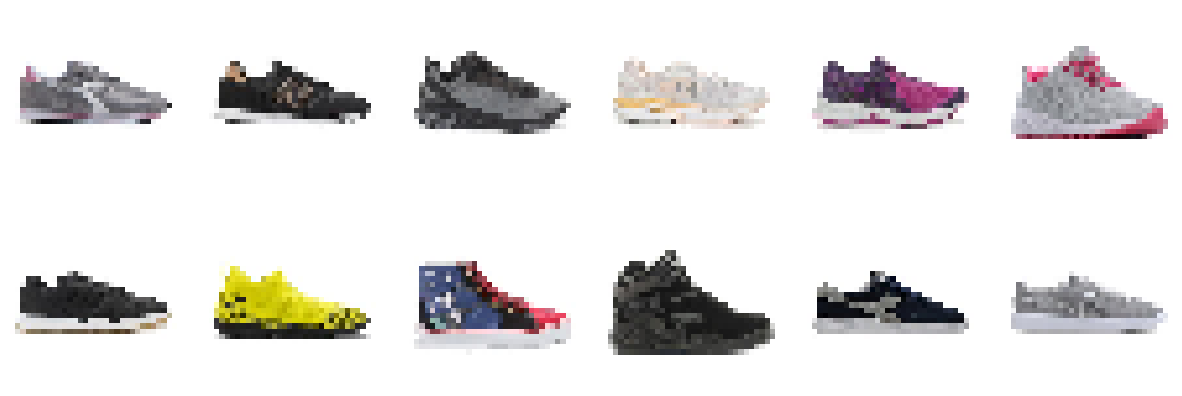

In [5]:
visualize_images(full_dataset, n_rows=2, n_cols=6, seed=0)


In [6]:
class QuantizedSneakers(Dataset):
    def __init__(self, base_dataset: Dataset, num_categories: int = 16, pack_channels: bool = True):
        self.base_dataset = base_dataset
        self.K = int(num_categories)
        self.pack_channels = bool(pack_channels)

        x0, _ = self.base_dataset[0]
        if not torch.is_tensor(x0) or x0.ndim != 3:
            raise ValueError(f"Expected base dataset to return tensor [C,H,W], got {type(x0)} with shape {getattr(x0, 'shape', None)}")

        self.C = int(x0.shape[0])
        self.H = int(x0.shape[1])
        self.W = int(x0.shape[2])

        if self.C > 1 and not self.pack_channels:
            raise ValueError("pack_channels=False only supported for grayscale (C=1)")

        self.W_packed = self.W * self.C if self.pack_channels else self.W
        self.S = int(self.H * self.W_packed)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        x = torch.clamp((x + 1.0) / 2.0, 0.0, 1.0)
        q = torch.clamp((x * (self.K - 1)).round().long(), 0, self.K - 1)

        if self.C > 1:
            q = torch.cat([q[c] for c in range(self.C)], dim=1)  # [H, W*C]
            return q, 0

        return q.squeeze(0), 0


def tokens_to_img01(x_tokens: torch.Tensor, meta: QuantizedSneakers) -> torch.Tensor:
    if x_tokens.ndim == 1:
        x_tokens = x_tokens.unsqueeze(0)
    if x_tokens.ndim == 2:
        B, S = x_tokens.shape
        x = x_tokens.view(B, meta.H, meta.W_packed)
    elif x_tokens.ndim == 3:
        x = x_tokens
        B = x.shape[0]
    else:
        raise ValueError(f"Unexpected tokens shape: {tuple(x_tokens.shape)}")

    x = x.float() / max(meta.K - 1, 1)

    if meta.C == 1:
        return x.view(B, 1, meta.H, meta.W).contiguous()

    chunks = torch.chunk(x, chunks=meta.C, dim=2)
    x_chw = torch.stack(chunks, dim=1)
    return x_chw.contiguous()


NUM_CATEGORIES = 128

quant_train_dataset = QuantizedSneakers(train_dataset, num_categories=NUM_CATEGORIES, pack_channels=True)
quant_test_dataset = QuantizedSneakers(test_dataset, num_categories=NUM_CATEGORIES, pack_channels=True)

train_loader = DataLoader(quant_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(quant_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

quant_train_dataset.C, quant_train_dataset.H, quant_train_dataset.W, quant_train_dataset.W_packed, quant_train_dataset.K


(3, 32, 32, 96, 128)

In [7]:
def cosine_schedule(T: int, eps: float = 1e-4):
    t = np.arange(0, T)
    alpha_bar_t = eps + (1.0 - eps) * np.cos(np.pi / 2 * t / T) ** 2
    alpha_bar_t_prev = np.roll(alpha_bar_t, 1)
    beta_t = 1.0 - alpha_bar_t / alpha_bar_t_prev
    beta_t[0] = 1.0 - alpha_bar_t[0]
    beta_t = np.clip(beta_t, 0.0, 1.0)
    alpha_t = 1.0 - beta_t
    return beta_t, alpha_t, alpha_bar_t


def uniform_kernel(beta_t: float, K: int):
    beta_t = float(beta_t)
    I = np.eye(K, dtype=np.float64)
    uniform_matrix = np.full((K, K), 1.0 / K, dtype=np.float64)
    Q_t = (1.0 - beta_t) * I + beta_t * uniform_matrix
    pi = np.full((K,), 1.0 / K, dtype=np.float64)
    return Q_t, pi


def train_step(model, x_0, optimizer, time_steps, Q, Q_bar, device):
    optimizer.zero_grad()

    batch_size = x_0.shape[0]
    K = Q_bar.shape[-1]

    t = torch.randint(1, time_steps, (batch_size,), device=device)

    x0_onehot = F.one_hot(x_0, num_classes=K).float()  # [B, S, K]
    Q_bar_t = Q_bar[t]  # [B, K, K]
    p_x_t = torch.einsum("bsk,bkj->bsj", x0_onehot, Q_bar_t)  # [B, S, K]
    x_t = torch.distributions.Categorical(probs=p_x_t).sample()

    logits_p_x_0 = model(x_t, t)  # [B, S, K]
    loss = F.cross_entropy(logits_p_x_0.transpose(1, 2), x_0)

    loss.backward()
    optimizer.step()

    return loss.item()


def eval_step(model, x_0, time_steps, Q, Q_bar, device):
    model.eval()

    batch_size = x_0.shape[0]
    K = Q_bar.shape[-1]

    t = torch.randint(1, time_steps, (batch_size,), device=device)

    x0_onehot = F.one_hot(x_0, num_classes=K).float()  # [B, S, K]
    Q_bar_t = Q_bar[t]  # [B, K, K]
    p_x_t = torch.einsum("bsk,bkj->bsj", x0_onehot, Q_bar_t)  # [B, S, K]
    x_t = torch.distributions.Categorical(probs=p_x_t).sample()

    with torch.no_grad():
        logits_p_x_0 = model(x_t, t)

    loss = F.cross_entropy(logits_p_x_0.transpose(1, 2), x_0)
    return loss.item()


@torch.no_grad()
def sample_d3pm(
    model,
    Q,
    Q_bar,
    device,
    init_probs,
    *,
    x_t=None,
    t_start=None,
    shape=None,
    eps=1e-10,
    return_intermediates: bool = False,
    intermediate_steps: list[int] | None = None,
):
    was_training = model.training
    model.eval()

    Q = Q.to(device=device)
    Q_bar = Q_bar.to(device=device)
    init_probs = init_probs.to(device=device)

    T = int(Q.shape[0])
    K = int(Q.shape[-1])

    if x_t is None:
        if shape is None:
            raise ValueError("Provide shape=(B,S) when x_t is None.")
        t_start = T - 1 if t_start is None else int(t_start)
        x_t = torch.distributions.Categorical(probs=init_probs).sample(shape)
    else:
        x_t = x_t.to(device=device)
        if t_start is None:
            raise ValueError("Provide t_start when x_t is given.")
        t_start = int(t_start)

    if not (0 <= t_start < T):
        raise ValueError(f"t_start must be in [0, {T-1}]")

    B = int(x_t.shape[0])

    if return_intermediates:
        steps = [] if intermediate_steps is None else [int(s) for s in intermediate_steps]
        step_set = set(steps)
        x0_hat_by_t: dict[int, torch.Tensor] = {}
        xtm1_by_t: dict[int, torch.Tensor] = {}
    else:
        steps = []
        step_set = set()
        x0_hat_by_t = {}
        xtm1_by_t = {}

    for t in reversed(range(1, t_start + 1)):
        t_batch = torch.full((B,), t, dtype=torch.long, device=device)

        logits_p_x_0 = model(x_t, t_batch)  # [B, S, K]
        pi = F.softmax(logits_p_x_0, dim=-1)

        if return_intermediates and t in step_set:
            x0_hat_by_t[t] = pi.argmax(dim=-1).detach().clone()

        Q_t = Q[t]
        Q_bar_t = Q_bar[t]
        Q_bar_tm1 = Q_bar[t - 1]

        j = x_t  # [B, S]
        Q_t_kj = Q_t[:, j]
        Q_bar_t_ij = Q_bar_t[:, j]

        Q_t_kj = Q_t_kj.permute(1, 2, 0).unsqueeze(2)  # [B, S, 1, K]
        Q_bar_t_ij = Q_bar_t_ij.permute(1, 2, 0).unsqueeze(-1)  # [B, S, K, 1]
        Q_bar_tm1_ik = Q_bar_tm1.unsqueeze(0).unsqueeze(0)  # [1, 1, K, K]

        posterior = Q_t_kj * Q_bar_tm1_ik / (Q_bar_t_ij + eps)  # [B, S, K, K]
        full_posterior = (pi.unsqueeze(-1) * posterior).sum(dim=2)  # [B, S, K]

        x_t = torch.distributions.Categorical(probs=full_posterior).sample()

        if return_intermediates and t in step_set:
            xtm1_by_t[t] = x_t.detach().clone()

    if return_intermediates and 0 in step_set:
        x0_hat_by_t[0] = x_t.detach().clone()
        xtm1_by_t[0] = x_t.detach().clone()

    if was_training:
        model.train()

    if return_intermediates:
        missing = [t for t in steps if t not in x0_hat_by_t or t not in xtm1_by_t]
        if missing:
            raise ValueError(f"Missing intermediates for timesteps: {missing}")
        x0_list = [x0_hat_by_t[t] for t in steps]
        xtm1_list = [xtm1_by_t[t] for t in steps]
        return x_t, x0_list, xtm1_list

    return x_t


In [8]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, emb_dim: int):
        super().__init__()
        self.emb_dim = int(emb_dim)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        half_dim = self.emb_dim // 2
        emb_power = torch.arange(half_dim, device=t.device) / max(half_dim - 1, 1)
        emb = 10_000.0 ** (-emb_power)
        emb = t[:, None].float() * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


class DDPMResAttnBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, t_emb_dim: int, num_heads: int = 4, use_attn: bool = True):
        super().__init__()
        self.use_attn = bool(use_attn)
        self.nonlinearity = nn.SiLU()

        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            self.nonlinearity,
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        self.time_proj = nn.Sequential(
            self.nonlinearity,
            nn.Linear(t_emb_dim, out_channels * 2),
        )

        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            self.nonlinearity,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        self.skip_conn = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        if self.use_attn:
            self.attn_norm = nn.GroupNorm(8, out_channels)
            self.mha = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

        nn.init.zeros_(self.conv_2[2].weight)
        nn.init.zeros_(self.conv_2[2].bias)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv_1(x)

        t_proj = self.time_proj(t_emb)
        scale, shift = t_proj.chunk(2, dim=1)
        scale = scale.unsqueeze(-1).unsqueeze(-1)
        shift = shift.unsqueeze(-1).unsqueeze(-1)
        h = (1 + scale) * h + shift

        h = self.conv_2(h)
        h = h + self.skip_conn(x)

        if self.use_attn:
            B, C, H, W = h.shape
            a = self.attn_norm(h).flatten(2).transpose(1, 2)  # [B,HW,C]
            a, _ = self.mha(a, a, a)
            a = a.transpose(1, 2).reshape(B, C, H, W)
            h = h + a

        return h


class Downsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            padding_mode="reflect",
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(self.up(x))


class UnetDiffusionModel(nn.Module):
    def __init__(
        self,
        *,
        K: int,
        H: int,
        W: int,
        emb_dim: int = 128,
        time_steps: int = 200,
        num_heads: int = 4,
        use_attention: bool = False,
    ):
        super().__init__()
        self.K = int(K)
        self.H = int(H)
        self.W = int(W)
        self.S = int(H * W)

        self.emb_dim = int(emb_dim)
        self.nonlinearity = nn.SiLU()

        self.time_emb = SinusoidalTimeEmbedding(self.emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(self.emb_dim, self.emb_dim * 4),
            self.nonlinearity,
            nn.Linear(self.emb_dim * 4, self.emb_dim),
        )

        self.data_emb = nn.Embedding(self.K, self.emb_dim)
        self.conv_in = nn.Conv2d(self.emb_dim, 32, kernel_size=3, padding=1, padding_mode="reflect")

        self.enc1 = DDPMResAttnBlock(32, 32, self.emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.down1 = Downsample(32, 32)

        self.enc2 = DDPMResAttnBlock(32, 64, self.emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.down2 = Downsample(64, 64)

        self.mid = DDPMResAttnBlock(64, 128, self.emb_dim, num_heads=num_heads, use_attn=use_attention)

        self.up3 = Upsample(128, 64)
        self.dec3 = DDPMResAttnBlock(64 + 64, 64, self.emb_dim, num_heads=num_heads, use_attn=use_attention)

        self.up2 = Upsample(64, 32)
        self.dec2 = DDPMResAttnBlock(32 + 32, 32, self.emb_dim, num_heads=num_heads, use_attn=use_attention)

        self.norm_out = nn.GroupNorm(8, 32)
        self.conv_out = nn.Conv2d(32, self.K, kernel_size=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        if x.ndim == 2:
            B, S = x.shape
            if S != self.S:
                raise ValueError(f"Expected S={self.S}, got S={S}")
            x = x.view(B, self.H, self.W)
        elif x.ndim == 3:
            B, H, W = x.shape
            if (H, W) != (self.H, self.W):
                raise ValueError(f"Expected (H,W)=({self.H},{self.W}), got ({H},{W})")
        else:
            raise ValueError(f"Expected x as [B,S] or [B,H,W], got shape {tuple(x.shape)}")

        x = x.long()
        t_emb = self.time_mlp(self.time_emb(t))

        x_emb = self.data_emb(x).permute(0, 3, 1, 2).contiguous()  # [B,D,H,W]
        h = self.conv_in(x_emb)

        e1 = self.enc1(h, t_emb)
        h = self.down1(e1)

        e2 = self.enc2(h, t_emb)
        h = self.down2(e2)

        h = self.mid(h, t_emb)

        h = self.up3(h)
        h = torch.cat([h, e2], dim=1)
        h = self.dec3(h, t_emb)

        h = self.up2(h)
        h = torch.cat([h, e1], dim=1)
        h = self.dec2(h, t_emb)

        h = self.norm_out(h)
        h = self.nonlinearity(h)
        logits = self.conv_out(h)  # [B,K,H,W]

        return logits.flatten(2).permute(0, 2, 1).contiguous()  # [B,S,K]


epoch 0: 100%|██████████| 323/323 [00:15<00:00, 20.97it/s]


epoch=0 train_loss=2.7846 test_loss=2.0009


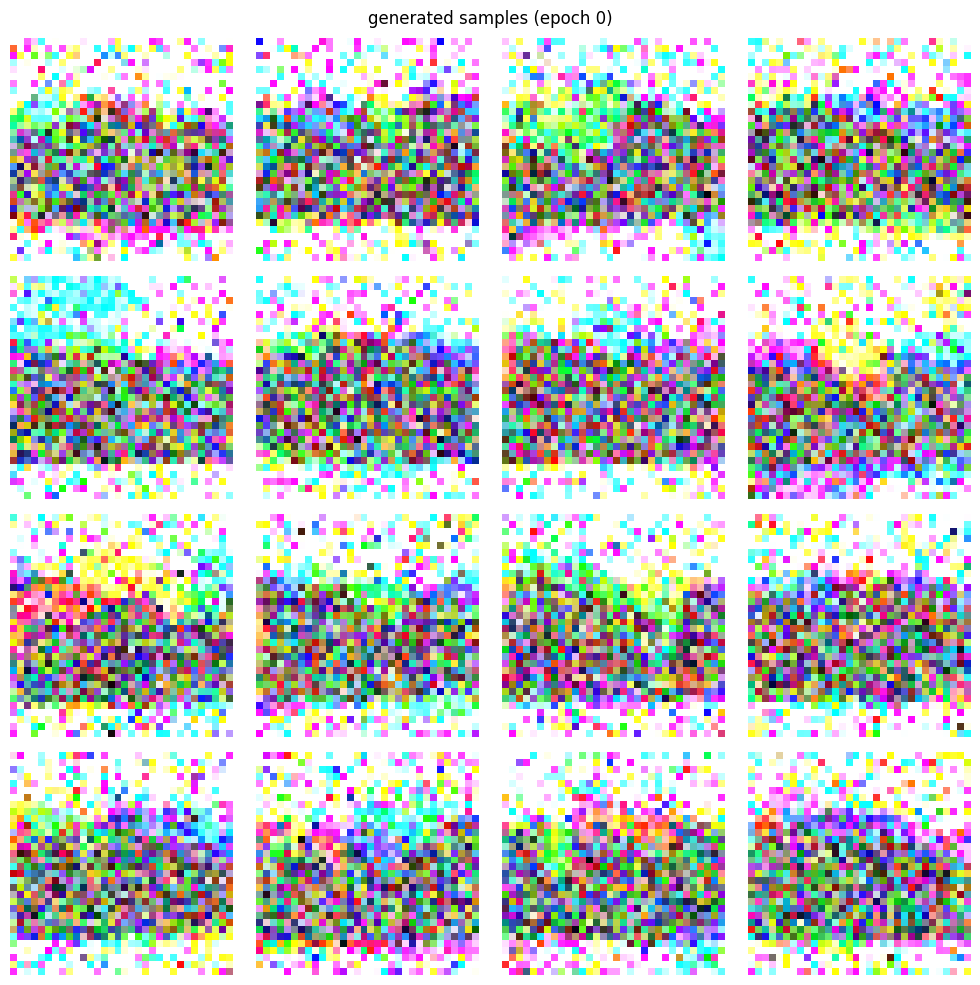

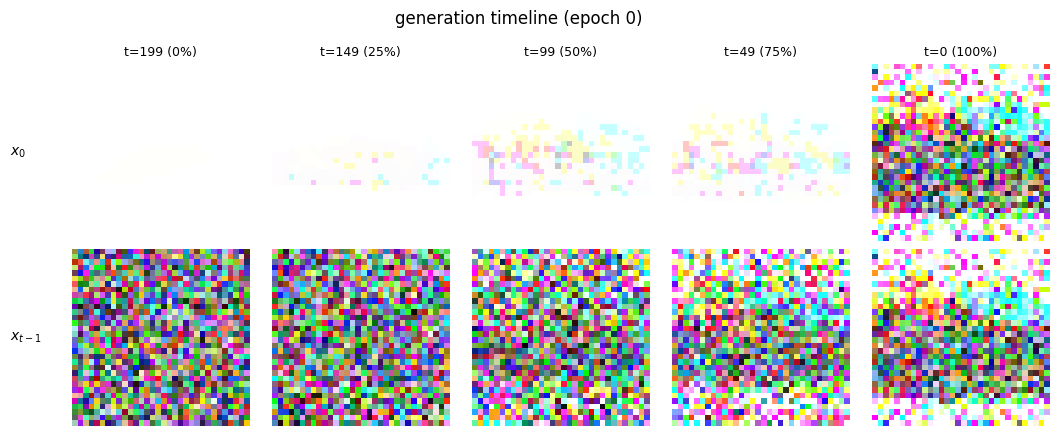

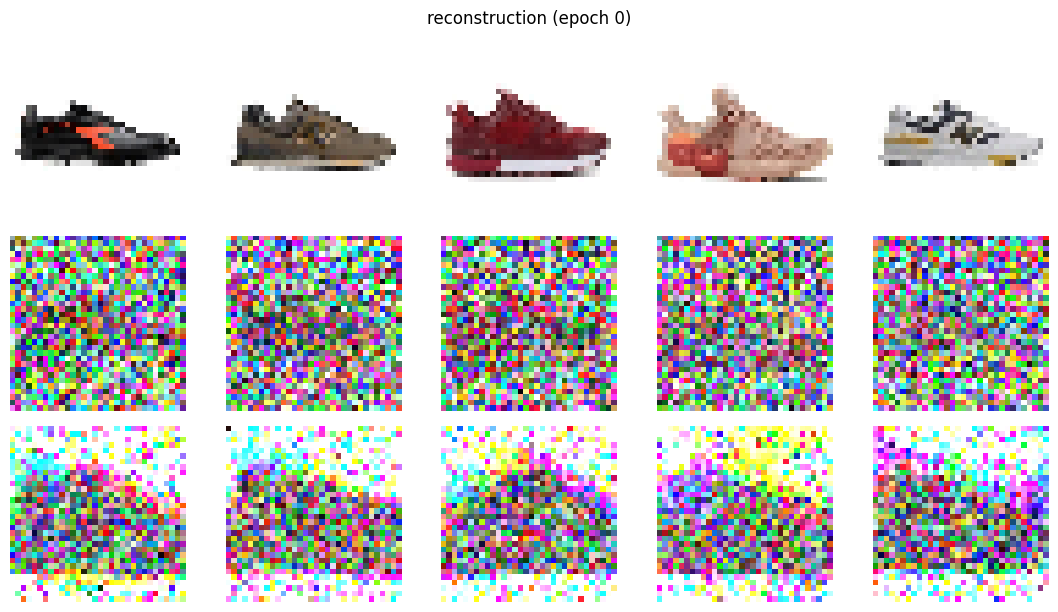

epoch 1: 100%|██████████| 323/323 [00:13<00:00, 23.52it/s]


epoch=1 train_loss=1.7320 test_loss=1.5523


KeyboardInterrupt: 

In [9]:
def _imshow01(ax, x_chw01: torch.Tensor):
    x = x_chw01.detach().cpu().float().clamp(0, 1)
    if x.shape[0] == 1:
        ax.imshow(x[0], cmap="gray", vmin=0, vmax=1)
    else:
        ax.imshow(x.permute(1, 2, 0))


def visualize_samples(imgs01: torch.Tensor, n_rows: int, n_cols: int, title: str | None = None):
    imgs = imgs01.detach().cpu().float().clamp(0, 1)
    B, C, H, W = imgs.shape

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    for i in range(n_rows * n_cols):
        ax = axes[i // n_cols, i % n_cols]
        ax.axis("off")
        if i >= B:
            continue
        _imshow01(ax, imgs[i])

    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig


def visualize_generation_samples(model, sample_fn, time_steps, epoch, k=16, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    cols = math.isqrt(k)
    rows = math.ceil(k / cols)
    imgs = sample_fn(n_samples=k, num_steps=time_steps)
    return visualize_samples(imgs, n_rows=rows, n_cols=cols, title=f"generated samples (epoch {epoch})")


@torch.no_grad()
def visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=None, percentages=None):
    if percentages is None:
        percentages = [0, 25, 50, 75, 100]

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    timestep_indices = [max(0, min(time_steps - 1, int((100 - p) / 100 * (time_steps - 1)))) for p in percentages]

    x0_list, xtm1_list = sample_fn(
        n_samples=1,
        num_steps=time_steps,
        return_intermediates=True,
        intermediate_steps=timestep_indices,
    )

    n_cols = len(percentages)
    fig, axes = plt.subplots(2, n_cols, figsize=(2.2 * n_cols, 4.4))
    axes = np.array(axes).reshape(2, n_cols)

    for col, (pct, t_val) in enumerate(zip(percentages, timestep_indices)):
        axes[0, col].axis("off")
        axes[1, col].axis("off")

        x0 = x0_list[col][0]
        xtm1 = xtm1_list[col][0]

        _imshow01(axes[0, col], x0)
        _imshow01(axes[1, col], xtm1)
        axes[0, col].set_title(f"t={t_val} ({pct}%)", fontsize=9)

    axes[0, 0].text(-0.35, 0.5, r"$x_0$", transform=axes[0, 0].transAxes, fontsize=10, va="center")
    axes[1, 0].text(-0.35, 0.5, r"$x_{t-1}$", transform=axes[1, 0].transAxes, fontsize=10, va="center")

    plt.suptitle(f"generation timeline (epoch {epoch})", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(left=0.09)
    return fig


@torch.no_grad()
def visualize_reconstruction_samples(
    model,
    sample_fn,
    Q_bar,
    time_steps,
    epoch,
    *,
    dataset,
    k=5,
    seed=None,
    t_noise=None,
):
    if dataset is None:
        raise ValueError("Pass a quantized (discrete-token) dataset via dataset=...")

    if t_noise is None:
        t_noise = int(0.75 * (time_steps - 1))
    t_noise = int(t_noise)
    if not (0 <= t_noise < time_steps):
        raise ValueError(f"t_noise must be in [0, {time_steps-1}]")

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    device = next(model.parameters()).device

    rng = np.random.default_rng(seed if seed is not None else 0)
    replace = len(dataset) < k
    idxs = rng.choice(len(dataset), size=k, replace=replace)

    x0_list = []
    for idx in idxs:
        x0, _ = dataset[int(idx)]
        x0_list.append(x0)

    x_0 = torch.stack(x0_list).to(device).long()  # [B,H,W_packed] or [B,H,W]
    x0_tokens = x_0.view(x_0.shape[0], -1)

    K = getattr(dataset, "K", None)
    if K is None:
        K = int(x0_tokens.max().item()) + 1
    K = int(K)

    Q_bar_t = Q_bar[t_noise].to(device)  # [K,K]
    x0_onehot = F.one_hot(x0_tokens, num_classes=K).to(torch.float32)  # [B,S,K]
    p_x_t = torch.einsum("bsk,kj->bsj", x0_onehot, Q_bar_t)  # [B,S,K]
    x_t_tokens = torch.distributions.Categorical(probs=p_x_t).sample()  # [B,S]

    recon = sample_fn(n_samples=k, num_steps=t_noise + 1, x_init=x_t_tokens)

    x0_img = tokens_to_img01(x0_tokens, dataset)
    xt_img = tokens_to_img01(x_t_tokens, dataset)

    fig, axes = plt.subplots(3, k, figsize=(2.2 * k, 6.2))
    axes = np.array(axes).reshape(3, k)

    for i in range(k):
        for r in range(3):
            axes[r, i].axis("off")
        _imshow01(axes[0, i], x0_img[i])
        _imshow01(axes[1, i], xt_img[i])
        _imshow01(axes[2, i], recon[i])

    axes[0, 0].set_ylabel("original", fontsize=10)
    axes[1, 0].set_ylabel(f"diffused (t={t_noise})", fontsize=10)
    axes[2, 0].set_ylabel("recon", fontsize=10)

    plt.suptitle(f"reconstruction (epoch {epoch})", fontsize=12)
    plt.tight_layout()
    return fig


def train_d3pm(
    model,
    train_dataloader,
    test_dataloader,
    *,
    num_epochs: int,
    learning_rate: float,
    time_steps: int,
    schedule_fn,
    transition_kernel_fn,
    device,
    sample_every: int = 1,
    viz_seed: int = 42,
):
    betas, _, _ = schedule_fn(time_steps)
    betas = torch.as_tensor(betas, device=device, dtype=torch.float32)

    x0_example, _ = next(iter(train_dataloader))
    x0_example = x0_example.to(device)
    S = int(np.prod(x0_example.shape[1:])) if x0_example.ndim > 2 else int(x0_example.shape[1])

    K = getattr(train_dataloader.dataset, "K", None)
    if K is None:
        K = int(x0_example.max().item()) + 1
    K = int(K)

    I = torch.eye(K, device=device, dtype=torch.float32)
    Q = torch.empty((time_steps, K, K), device=device, dtype=torch.float32)
    Q_bar = torch.empty_like(Q)
    Q[0] = I
    Q_bar[0] = I

    init_probs = None
    for t in range(1, time_steps):
        Q_t, pi = transition_kernel_fn(float(betas[t].item()), K)
        Q_t = torch.as_tensor(Q_t, device=device, dtype=torch.float32)
        Q[t] = Q_t
        Q_bar[t] = Q_bar[t - 1] @ Q_t
        if init_probs is None:
            init_probs = torch.as_tensor(pi, device=device, dtype=torch.float32)

    if init_probs is None:
        init_probs = torch.full((K,), 1.0 / K, device=device, dtype=torch.float32)

    meta = train_dataloader.dataset

    def sample_fn(
        n_samples: int,
        num_steps: int,
        x_init: torch.Tensor | None = None,
        *,
        return_intermediates: bool = False,
        intermediate_steps: list[int] | None = None,
    ):
        if x_init is None:
            out = sample_d3pm(
                model,
                Q,
                Q_bar,
                device,
                init_probs,
                shape=(n_samples, S),
                t_start=num_steps - 1,
                return_intermediates=return_intermediates,
                intermediate_steps=intermediate_steps,
            )
        else:
            x_init = x_init.to(device=device).view(n_samples, -1).long()
            out = sample_d3pm(
                model,
                Q,
                Q_bar,
                device,
                init_probs,
                x_t=x_init,
                t_start=num_steps - 1,
                return_intermediates=return_intermediates,
                intermediate_steps=intermediate_steps,
            )

        if return_intermediates:
            x_tokens, x0_list, xtm1_list = out
            x0_imgs = [tokens_to_img01(t, meta) for t in x0_list]
            xtm1_imgs = [tokens_to_img01(t, meta) for t in xtm1_list]
            return x0_imgs, xtm1_imgs

        x_tokens = out
        return tokens_to_img01(x_tokens, meta)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        n_batches = 0

        for x_0, _ in tqdm(train_dataloader, desc=f"epoch {epoch}"):
            x_0 = x_0.to(device)
            if x_0.ndim > 2:
                x_0 = x_0.view(x_0.shape[0], -1)
            loss = train_step(model, x_0.long(), optimizer, time_steps, Q, Q_bar, device)
            total_loss += float(loss)
            n_batches += 1

        avg_train_loss = total_loss / max(n_batches, 1)

        model.eval()
        total_test_loss = 0.0
        n_test_batches = 0
        with torch.no_grad():
            for x_0, _ in test_dataloader:
                x_0 = x_0.to(device)
                if x_0.ndim > 2:
                    x_0 = x_0.view(x_0.shape[0], -1)
                loss = eval_step(model, x_0.long(), time_steps, Q, Q_bar, device)
                total_test_loss += float(loss)
                n_test_batches += 1
        avg_test_loss = total_test_loss / max(n_test_batches, 1)

        print(f"epoch={epoch} train_loss={avg_train_loss:.4f} test_loss={avg_test_loss:.4f}")

        if sample_every > 0 and (epoch % sample_every == 0 or epoch == num_epochs - 1):
            fig1 = visualize_generation_samples(model, sample_fn, time_steps, epoch, k=16, seed=viz_seed)
            plt.show()
            plt.close(fig1)

            fig2 = visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=viz_seed)
            plt.show()
            plt.close(fig2)

            fig3 = visualize_reconstruction_samples(
                model,
                sample_fn,
                Q_bar,
                time_steps,
                epoch,
                dataset=meta,
                k=5,
                seed=viz_seed,
            )
            plt.show()
            plt.close(fig3)


TIME_STEPS = 200
LEARNING_RATE = 2e-4
NUM_EPOCHS = 5

model = UnetDiffusionModel(
    K=quant_train_dataset.K,
    H=quant_train_dataset.H,
    W=quant_train_dataset.W_packed,
    emb_dim=128,
    time_steps=TIME_STEPS,
    num_heads=4,
    use_attention=False,
).to(device)

train_d3pm(
    model,
    train_loader,
    test_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    time_steps=TIME_STEPS,
    schedule_fn=cosine_schedule,
    transition_kernel_fn=uniform_kernel,
    device=device,
    sample_every=1,
)
